In [267]:
%pip install haversine


In [268]:
import pandas as pd
import numpy as np
import sys, math, os, json, re, random
import scipy.stats as stats
import scipy.linalg as scl
import matplotlib.pyplot as plt
import seaborn as sns
import itertools
from haversine import haversine, Unit

# jupyter magic to display plots directly in the notebook
%matplotlib inline

# use vector graphics format for nicer plots
%config Inline.Backend.figure_format = 'svg'

In [269]:
from google.colab import drive
drive.mount('/content/drive/')
data_df = pd.read_csv("/content/drive/MyDrive/ProjectData.csv")

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [270]:
np.random.seed(0)

In [271]:
data_df.head()

call_locations = [(data_df['Lat'][i],data_df['Lon'][i]) for i in range(len(data_df['Lon']))]

In [272]:
len(data_df[data_df['CancelDelay'] == 0])/len(data_df)

time = data_df['Time']
#count the day
days = np.ceil(time /24)
counts = np.zeros (24)
for i in range(data_df.shape[0]):
# calculate if arrival occured in different periods
  interval = int(time[i]) % 24
# increment counter for interval arrival fell in
  counts[interval] += 1
# divide counts by interval width∗num days to get
#average hourly arrivals in each interval (which is the MLE)
MLEs = counts /(max(days ))
MLEs

array([0.72252747, 0.61813187, 0.37362637, 0.31868132, 0.26648352,
       0.27747253, 0.48901099, 0.77747253, 1.69505495, 2.74725275,
       3.19230769, 3.71978022, 3.96428571, 3.67307692, 3.81318681,
       3.68406593, 3.56043956, 3.1978022 , 3.05494505, 2.28021978,
       1.3956044 , 1.17032967, 0.88186813, 0.81318681])

In [273]:
df = data_df[data_df['Safe to fly']== 1]
df[df['CancelDelay'] == 0]['CancelDelay'].shape[0]/ df.shape[0]

0.9119879596911399

CallFinishesAtHD:
Generate random outcome of safe to fly

If not safe:
Update heli status to AtBase, note outcome, remove call from active list.
else:

Set heli status to PrepForCall
Generate the time at which the helicopter completes prep, τ say.

If call cancellation time < τ:

Schedule a CallCancelled event at time τ

else:

Schedule a HeliDepartsForCall event at time τ

In [274]:
np.random.binomial(1,1)

1

In [275]:
hosp_loc = np.array ([[41.979 , 76.5155] , [42.6526 , 73.7562] ,
[43.0481 , 76.1474] ,
[43.1566 , 77.6088] ,
[42.0898 , 76.8077] ,
[42.0987 , 75.918 ],
[42.444 , 76.5019] ,
[42.8864 , 78.8784] ,
[43.1009 , 75.2327] ,
[43.9748 , 75.9108]])

trama_center_loc = np.array ([[41.979 , 76.5155] , [42.6526 , 73.7562] ,
[43.0481 , 76.1474] ,
[43.1566 , 77.6088]])

In [276]:
class ActiveCall:
    def __init__(self,location_of_call, timeReceived, callIndex):
        self.location = location_of_call
        self.callIndex = callIndex
        self.lat = location_of_call[0]
        self.long = location_of_call[1]
        self.timeReceived = timeReceived
        self.heliIndex = []
        self.canceled = False

        cancelation_early = np.random.binomial(1,1-0.912)
        if cancelation_early == 1:
          self.cancelTime = timeReceived+ np.random.exponential(0.205)
        else:
          self.cancelTime = timeReceived+ 2



    def set_heliIndex(self,heliIndex):
      self.heliIndex.append(heliIndex)
      return 


class Helicopter:
    def __init__(self, base_location, index):
        self.index = index
        self.AtBase = True
        self.AwaitingClearance = False
        self.PrepForCall = False
        self.OnWayToScene = False
        self.AtScene = False
        self.OnWayToHospital = False
        self.AtHosp = False
        self.OnWayToBase = False

        self.time_to_reach_call = None
        self.distance_to_call = None

        self.destination = None #lat,long
        self.indexActiveCall = []
        self.base_location = base_location
        self.cancelLocation = []
        self.lat = base_location[0]
        self.long = base_location[1]

        self.recieved_time = None
        self.current_time = None
        self.HD_delay_time = None
        self.time_to_reach_base = None
        self.isCallSafe = None
        self.prep_delay = None
        self.call_location = None

        self.timeAtScene = None

        self.toTrauma = None

        self.time_to_reach_hospital = None
        
    def getLat(self):
        return self.destination[0]
    def getLong(self):
        return self.destination[1]

    def setCallReceiveTime(self, current_time):
      
      self.recieved_time = current_time
      self.HD_delay_time = current_time + np.random.triangular(1/12,7/60,1/6)
      self.current_time = self.HD_delay_time
      return 

    def CallCanceled(self,cancelTime=None):
      
      

      if self.PrepForCall or self.AwaitingClearance:
        self.cancelLocation = self.base_location
        self.AtBase = True
        self.PrepForCall = False
        self.AwaitingClearance = False
        if len(self.indexActiveCall) >0:
          del self.indexActiveCall[-1]

        


      elif self.OnWayToScene and cancelTime != None:
        
        proportion = cancelTime/ self.time_to_reach_call
        x_coord = abs(self.call_location[0]-self.base_location[0])*proportion 
        y_coord = abs(self.call_location[1]-self.base_location[1])*proportion 
        if self.call_location[0]>self.base_location[0]:
          x_coord = self.base_location[0]+x_coord
        else:
          x_coord = self.base_location[0] - x_coord

        if self.call_location[1]>self.base_location[1]:
          y_coord = self.base_location[1]+y_coord
        else:
          y_coord = self.base_location[1] - y_coord 

        self.cancelLocation = (x_coord,y_coord)
        self.OnWayToScene = False
        self.OnWayToBase = True
        self.destination = self.base_location
        #if in the air, it will take the cancelation time to return
        self.time_to_reach_base = cancelTime + haversine(self.cancelLocation,self.destination)/160
        #print(f'Call was canceled at location {self.cancelLocation}')

      return 






        
    def set_AwaitingClearance(self, call_index):
        self.AwaitingClearance = True
        self.indexActiveCall.append(call_index)
        return 

    def CallFinishesAtHD(self):
        ##from project hw q 1
      
      self.isCallSafe = np.random.binomial(1,1-.101)
      if self.isCallSafe != 1:
        self.CallCanceled()
      else:
        self.PrepForCall = True
        self.AwaitingClearance = False
        self.prep_delay = self.current_time +np.random.triangular(5/60,7.5/60,10/60)
        self.current_time = self.prep_delay
      return 


    def HeliDepartsForCall(self, call_location):
      self.AtBase = False
      self.PrepForCall = False
      self.OnWayToScene = True
      
      self.call_location = call_location
      self.destination = call_location

      self.distance_to_call = haversine(self.destination,self.base_location)


      self.time_to_reach_call = haversine(self.destination,self.base_location)/160 + self.current_time

      return 
      

    def HeliArrivesAtScene(self):
      
      self.current_time = self.time_to_reach_call
      self.OnWayToScene = False
      self.AtScene = True
      
      self.lat = self.destination[0]
      self.long = self.destination[1]
      #Scene time is gamma a = 2.95,scale = 0.12) 
      self.timeAtScene = np.random.gamma(2.95,.12)
      self.current_time += self.timeAtScene

      return 



    def HeliDepartsFromScene(self):
#      Generate a random outcome ToTrauma as a Bernoulli rv

      self.toTrauma = np.random.binomial(1,1-0.807)
      #print(str(self.toTrauma)+" is the trauma center prob")
      self.AtScene = False  
      self.OnWayToHospital = True

      if self.toTrauma ==1:
        self.destination = self.findNearestTraumaCenter()
      else:
        self.destination = self.findNearestHospital()
      
      self.time_to_reach_hospital = haversine(self.destination,(self.lat,self.long))/160

      return 

    def findNearestTraumaCenter(self):
      trama_center_loc = np.array ([[41.979 , 76.5155] , [42.6526 , 73.7562] ,[43.0481 , 76.1474] ,[43.1566 , 77.6088]])

      current_min = float('inf')
      closest_center = None
      for center in trama_center_loc:
        if haversine((self.lat,self.long),center)<current_min:
          current_min = haversine((self.lat,self.long),center)
          closest_center = center
      return closest_center

    def findNearestHospital(self):
      hosp_loc = np.array ([[41.979 , 76.5155] , [42.6526 , 73.7562] , [43.0481 , 76.1474] ,[43.1566 , 77.6088] ,[42.0898 , 76.8077] ,[42.0987 , 75.918 ],[42.444 , 76.5019] ,[42.8864 , 78.8784] ,[43.1009 , 75.2327] ,[43.9748 , 75.9108]])

      current_min = float('inf')
      closest_center = None
      for center in hosp_loc:
        if haversine((self.lat,self.long),center)<current_min:
          current_min = haversine((self.lat,self.long),center)
          closest_center = center
      return closest_center

            

    def HeliArrivesAtHosp(self):
      
      self.current_time += self.time_to_reach_hospital
      self.OnWayToHospital = False
      self.AtHosp = True
      self.OnWayToBase = False
      
      self.lat = self.destination[0]
      self.long = self.destination[1]
      return 

    def HeliDepartsHosp(self):
      self.AtHosp = False
      self.OnWayToBase = True

      self.time_to_reach_base = haversine((self.lat,self.long),self.base_location)/160 + self.current_time


      return 

    def HeliArrivesAtBase(self):
        self.current_time = self.time_to_reach_base
        self.AtBase = True
        self.OnWayToBase = False
        self.lat = self.base_location[0]
        self.long = self.base_location[1]
        self.time_to_reach_base = None
        return 
        
    def getTimeFromAtoB(A, B):
        return haversine((A[0],A[1]), (B[0],B[1]))/160


## 
TO DO : find the time it takes for helicopter to go from scene to hospital
We need the distribution / probability that a call recieved is accepted or rejected

Service time at hospital (gamma)
service time at scene (gamma)

We need to include some counter for how much time we are adding to our initial time

The logic for each event is as follows:
(a) CallArrival:


•Generate the CancelTime for the new call as current time plus a sample from
the cancellation delay distribution (t + tc)

Check if there is an available helicopter that is within range.

If so, choose the closest helicopter:

Add the new call to the list of active calls.

Set the HeliIndex for the new call to that helicopter

Update the helicopter status to AwaitingClearance and set its CallIndex to point to the call

Generate an HDDelayTime td.

If t + td < t + tc :

Schedule a CallFinishesAtHD event at t + HDDelayTime (t + td)
else:
Schedule a CallCancelled event at time CancellationTime (t + tc)
else:
Note that no heli was available in range

•Generate the next CallArrival event.

In [277]:
base_loc = {'Buffalo': (42.887691,78.879372), 'Rochester' : (43.156578,77.608849), 'Elmira' : (42.089794,76.807732), 'Ithaca' : (42.440498,76.495697), 'Sayre' : (41.980655,76.516197), 'Watertown' : (43.972382,75.911247), 'Syracuse' : (43.048122,76.147424), 'Binghamton' : (42.097122,75.911666), 'Utica' : (43.100903,75.232664), 'Albany' : (42.683761,73.733108)}

Buffalo = (42.887691,78.879372)
Rochester = (43.156578,77.608849)
Elmira = (42.089794,76.807732)
Ithaca = (42.440498,-76.495697)
Sayre = (41.980655,-76.516197)
Watertown = (43.972382,-75.911247)
Syracuse = (43.048122,-76.147424)
Binghamton = (42.097122,-75.911666)
Utica = (43.100903,-75.232664)
Albany = (42.683761,-73.733108)




In [278]:
# P(call is accepted or rejected) = P(out of range) + P(cancelled due to bad whether) = 0.1007 + 0.188 = 0.2887 chance rejection, 0.7113 chance call accepted
# CI for above? 99.5% CI for each range and weather => 99% CI bonferroni it's cancelled as opposed to single proportion


In [279]:
# function to find the helicopter with shortest distance from call
def check_helicopters_in_range(new_call, helicopter_list):
  
  closest_helicopter = None
  heli_index = -1
  min_distance = float('inf')
  for idx, helicopter in enumerate(helicopter_list):
    if helicopter.AtBase == True:
      heli_location = helicopter.base_location
      distance_to_helicopter= haversine(heli_location, new_call.location)
      #print(distance_to_helicopter)
      
      if distance_to_helicopter < min_distance and distance_to_helicopter <180:
        min_distance = distance_to_helicopter
        closest_helicopter = helicopter
        heli_index = idx
    

  if closest_helicopter != None:
    return closest_helicopter,heli_index
  else:
    return -1,-1


In [280]:
def process(current_time, helicopter_list,new_call):
  global active_calls
  global event_list
  
  global num_calls_dispatched
  global total_heli_distance_to_calls
  global total_reponse_time_per_heli
  global successfull_arrivals_per_heli

  global calls_canceled

  global total_response_time
  global total_time_to_definitive_care
  global number_of_trauma_centers

  global num_helis_arriving_at_scene

  global sucessful_transportation
  global utilization_per_helicopter
  
  for helicopter in helicopter_list:
    if helicopter.time_to_reach_base != None:
      #print(f'helicopter {helicopter.index} should reach base at {helicopter.time_to_reach_base}')
      if helicopter.AtBase == False and helicopter.time_to_reach_base< current_time:
        helicopter.HeliArrivesAtBase()


  event_list.append(new_call.callIndex)

  active_calls.append(new_call)

  

  helicopter,heli_idx = check_helicopters_in_range(new_call, helicopter_list)
  if helicopter == -1:
    #print('no helis in range')
    #print("append to call canceled")
    calls_canceled.append(new_call.location)
    new_call.set_heliIndex(heli_idx)
    return
  helicopter.set_AwaitingClearance(new_call.callIndex)

  new_call.set_heliIndex(heli_idx)

  #helicopter awaiting clearance and set its hd delay time

  helicopter.setCallReceiveTime(current_time)

  #print(current_time)
  #print(helicopter.current_time)
  #print(new_call.cancelTime)
  #print()
  if helicopter.HD_delay_time > new_call.cancelTime:
    helicopter.CallCanceled()
   # print(f'call was canceled becase time after HD delay {helicopter.HD_delay_time} is larger than cancel time {new_call.cancelTime}')

    calls_canceled.append(helicopter.cancelLocation)
    active_calls.remove(new_call)
    #print('call from ' +str( new_call.location) + ' took too long to process')
    return 

    #print(str(helicopter.current_time) + ' is the time before we prep after HD approves')

  helicopter.CallFinishesAtHD()

  if helicopter.PrepForCall:
    if helicopter.prep_delay> new_call.cancelTime:
     # print(f'prep delay of {helicopter.prep_delay} is larger than cancel time {new_call.cancelTime}')
      helicopter.CallCanceled()
      calls_canceled.append(helicopter.cancelLocation)
      active_calls.remove(new_call)
      return 
      
    else:
      
      helicopter.HeliDepartsForCall(new_call.location)
      num_calls_dispatched += 1
      
      total_heli_distance_to_calls += helicopter.distance_to_call
      
      
     # print(f'{helicopter.current_time} is just before we depart to the call')
     # print(f'{helicopter.time_to_reach_call} is the time when we reach call')
     # print(f'{new_call.cancelTime}  would be when cancelation occurs')
      if helicopter.time_to_reach_call> new_call.cancelTime:
        #print(f'Location when we cancel the call is {helicopter.cancelLocation} and its base origin is {helicopter.base_location}')
        #print(f'time when we reach the call {helicopter.time_to_reach_call} is larger than cancel time {new_call.cancelTime}')
        helicopter.CallCanceled(new_call.cancelTime)
        calls_canceled.append(helicopter.cancelLocation)
        #print(str(helicopter.current_time) + ' is the time when we reach hospital')

        return 

        #print('call canceled at ' + str(helicopter.cancelLocation))
        #print('helicopter gets back to base at '+ str(helicopter.time_to_reach_base))
      else:
        #print(str(helicopter.current_time) + ' is the time after we go from base to before we reach scene')
        #print(str(helicopter.time_to_reach_base) + ' is the time to reach scene')

        helicopter.HeliArrivesAtScene()

        total_response_time += (helicopter.time_to_reach_call - helicopter.recieved_time)
        total_reponse_time_per_heli[new_call.heliIndex] += (helicopter.time_to_reach_call - helicopter.recieved_time)  
        num_helis_arriving_at_scene +=1
        successfull_arrivals_per_heli[new_call.heliIndex] +=1
        #print(str(helicopter.current_time) + ' is the time after we reach scene')


        helicopter.HeliDepartsFromScene()
        #print(str(helicopter.current_time) + ' is the time after we leave the scene to the hospital')
        total_time_to_definitive_care += helicopter.time_to_reach_hospital
        if helicopter.toTrauma == 1:
          number_of_trauma_centers +=1


        helicopter.HeliArrivesAtHosp()
        helicopter.HeliDepartsHosp()
        #print(str(helicopter.time_to_reach_base) + ' is the time when we get to the base')
        #print(f'Heli number {new_call.heliIndex[-1]} will get back at {helicopter.time_to_reach_base}')

        sucessful_transportation += 1
        utilization_per_helicopter[new_call.heliIndex] +=1
        active_calls.remove(new_call) # call is no longer active
        return 

  else:
    #print("Call is canceled its not safe to fly")
    #print("append to call canceled")
    helicopter.CallCanceled()
    calls_canceled.append(helicopter.cancelLocation)
    active_calls.remove(new_call)
    return 





    

In [281]:
# generate arrivals
def generateHourlyCalls(number_of_days):
  location_of_calls = call_locations
  arrival_rates = {}
  for i in range(1,len(MLEs)+1):
    arrival_rates[i] = MLEs[i-1]
  

  time_of_arrivals = []
  lower_bound= 0
  upper_bound = 1
  for i in range(number_of_days):
    arrivals_per_hour = [np.random.poisson(rate) for rate in arrival_rates.values()]
    for hourly_calls in arrivals_per_hour:
      if hourly_calls>0:
        time_of_arrivals.extend(np.random.uniform(lower_bound,upper_bound,hourly_calls))
      lower_bound+=1
      upper_bound +=1
  time_of_arrivals.sort()
  call_list = []

  for i in range(len(time_of_arrivals)):
    location_idx = np.random.choice(len(location_of_calls),1)
    location = location_of_calls[location_idx[0]]
    location_of_calls.pop(location_idx[0])

    current_time = round(time_of_arrivals[i],5)
    callIndex = i
    new_call = ActiveCall(location,current_time, callIndex)
    call_list.append(new_call)
  return call_list




In [282]:
base_loc


{'Albany': (42.683761, 73.733108),
 'Binghamton': (42.097122, 75.911666),
 'Buffalo': (42.887691, 78.879372),
 'Elmira': (42.089794, 76.807732),
 'Ithaca': (42.440498, 76.495697),
 'Rochester': (43.156578, 77.608849),
 'Sayre': (41.980655, 76.516197),
 'Syracuse': (43.048122, 76.147424),
 'Utica': (43.100903, 75.232664),
 'Watertown': (43.972382, 75.911247)}

Buffalo - Erie county, Rochester- munroe county, Ithaca - Tompkins county, Syracuse - onondonga county, Albany - Albany county (top 5 most dense upstate NY counties with 100k+ people), Binghamtom

*Percentage* of calls dispatched: The percentage of calls where a helicopter is dispatched. (A call is not 
dispatched if it is unsafe to fly or if no helicopters are available within range.) 


• Average response time: The response time for a call is the time interval from the moment the call is received at the HD to the moment the helicopter arrives at scene. This average is computed only over  those calls for which a helicopter arrives at scene. 

• Time to definitive care: This is the time interval from the moment the call is received at the HD to the moment the patient reaches the receiving facility. Since this is closely related to the response time, we 
do not consider it further in this project. 

• Response fraction: This is the fraction of calls received at the HD where a helicopter arrives at the scene. 

• Utilization  of  helicopters:  This  is  computed  by  finding  the  average  number  of  calls  satisfactorily 
transported per day and dividing by the number of helicopters. It is an important metric for measuring 
the cost/profitability of the service. 

- utlization per helicopter

- average distance traveled per call that is responded to


In [283]:
#By largest population density
np.random.seed(0)
number_of_days_in_sim = 14
arrival_calls = generateHourlyCalls(number_of_days_in_sim)


In [286]:
np.random.seed(0)

helicopter_list = [Helicopter(base_loc['Buffalo'],0),Helicopter(base_loc['Buffalo'],1),
                   Helicopter(base_loc['Syracuse'],2),Helicopter(base_loc['Binghamton'],3),
                   Helicopter(base_loc['Rochester'],4), Helicopter(base_loc['Albany'],5)
                   ]
active_calls=[]
event_list=[]
calls_canceled = []
num_calls_dispatched = 0
total_response_time = 0
total_time_to_definitive_care = 0
number_of_trauma_centers = 0
num_helis_arriving_at_scene = 0
sucessful_transportation = 0
utilization_per_helicopter = np.zeros(12)
total_heli_distance_to_calls = 0
total_reponse_time_per_heli = np.zeros(12)
successfull_arrivals_per_heli = np.zeros(12)



for idx, call in enumerate(arrival_calls):
  #warm up for a day first
  # if idx == 44:
  #   calls_canceled = []
  #   num_calls_dispatched = 0
  #   total_response_time = 0
  #   total_time_to_definitive_care = 0
  #   number_of_trauma_centers = 0
  #   num_helis_arriving_at_scene = 0
  #   sucessful_transportation = 0
  #   utilization_per_helicopter = np.zeros(12)
  #   total_heli_distance_to_calls = 0
  #   total_reponse_time_per_heli = np.zeros(12)
  
  process(call.timeReceived,helicopter_list,call)
  #print()

total_number_of_calls = len(arrival_calls) 
number_of_days_in_sim = number_of_days_in_sim

print(f'The number of total calls is {total_number_of_calls}')

print(f'The number of canceled calls is {len(calls_canceled)}')
print(f'The percentage of dispatched calls is {round(num_calls_dispatched/ total_number_of_calls *100,2)}%\n')

print(f'Average distance a heli is travelng is {total_heli_distance_to_calls / (num_calls_dispatched)} KM\n')

print(f'Average response time for a heli is {total_response_time *60 / (num_helis_arriving_at_scene)} minutes')

total_reponse_time_per_heli = [total_reponse_time_per_heli[i]*60/successfull_arrivals_per_heli[i] for i in range(len(helicopter_list))]
response_time_dict = {i:total_reponse_time_per_heli[i] for i in range(len(total_reponse_time_per_heli))}
print(f"The avg response time per each helicopter is {response_time_dict}")
print(f"Helicopter with lowest response time is heli # {np.argmin(total_reponse_time_per_heli)} with time of {response_time_dict[np.argmin(total_reponse_time_per_heli)]}")
print(f"Helicopter with highest response time is heli # {np.argmax(total_reponse_time_per_heli)} with time of {response_time_dict[np.argmax(total_reponse_time_per_heli)]}")
print()

#print(f'We end up transporting {number_of_trauma_centers/total_number_of_calls} of calls to trauma centers')

print(f'Average time to get to the hospital is {total_time_to_definitive_care *60 / (num_helis_arriving_at_scene)} minutes\n')

print(f' The fraction of calls canceled is {len(calls_canceled)/total_number_of_calls}')

print(f'The response fraction is {num_helis_arriving_at_scene / total_number_of_calls} \n')

print(f'The average call utilization of each helicopter per day is {(sucessful_transportation/number_of_days_in_sim)/len(helicopter_list)}')

utilization_per_helicopter = utilization_per_helicopter/number_of_days_in_sim
utilization_dict = {i:utilization_per_helicopter[i] for i in range(len(utilization_per_helicopter))}
print(f"The utilization rate per each helicopter is {utilization_dict}")
print(f"Helicopter with lowest utilization is heli # {np.argmin(utilization_per_helicopter)} with utilization of {utilization_dict[np.argmin(utilization_per_helicopter)]}")
print(f"Helicopter with highest utilization is heli # {np.argmax(utilization_per_helicopter)} with utilization of {utilization_dict[np.argmax(utilization_per_helicopter)]}")

print()

The number of total calls is 650
The number of canceled calls is 250
The percentage of dispatched calls is 62.92%

Average distance a heli is travelng is 66.62848722899399 KM

Average response time for a heli is 39.8947906412603 minutes
The avg response time per each helicopter is {0: 32.41645758396353, 1: 31.107219912721707, 2: 42.78692734630169, 3: 46.71581501752341, 4: 48.88498105743164, 5: 34.83035385181733}
Helicopter with lowest response time is heli # 1 with time of 31.107219912721707
Helicopter with highest response time is heli # 4 with time of 48.88498105743164

Average time to get to the hospital is 9.465694793723719 minutes

 The fraction of calls canceled is 0.38461538461538464
The response fraction is 0.6153846153846154 

The average call utilization of each helicopter per day is 4.761904761904762
The utilization rate per each helicopter is {0: 5.571428571428571, 1: 2.5714285714285716, 2: 9.642857142857142, 3: 8.571428571428571, 4: 6.571428571428571, 5: 5.928571428571429,

In [289]:
np.mean(total_reponse_time_per_heli)

39.456959128293214

In [ ]:
def plot_calls(arrival_calls, calls_canceled):

  latN = 45.2
  latS = 40.2
  lonW = 80.0
  lonE = 71.8

  lat_base = [base[0] for base in base_loc.values()]
  lon_base = [base[1] for base in base_loc.values()]
  import matplotlib.image as mpimg
  fig = plt.figure(figsize=(18,12))
  ny_img=mpimg.imread('/content/drive/My Drive/ny.jpeg') #https://gisgeography.com/wp-content/uploads/2020/02/New-York-County-Map.jpg
  plt.title("Map of Successful Responses (Orange) and Canceled Responses (Blue)", size = 18)
  plt.xlabel("Long")
  plt.ylabel("Lat")
  plt.imshow(ny_img, extent=[lonW, lonE, latS, latN], alpha=0.5)

  for call in arrival_calls:
    call_loc = call.location
    plt.scatter(x=call_loc[1], y=call_loc[0], color = 'orange',zorder = 1, label='success')
  plt.legend(labels = ['Sucessful Call', "Canceled Call"])

  for cancel_loc in calls_canceled:
    plt.scatter(x=cancel_loc[1], y=cancel_loc[0],color = 'blue',zorder = 2,label = 'cancel')


  # for i, txt in enumerate(base_loc.keys()):
  #     plt.scatter(x=lon_base[i], y=lat_base[i], color = 'red')
  #     plt.text(lon_base[i], lat_base[i],txt+' Base', size = 12)

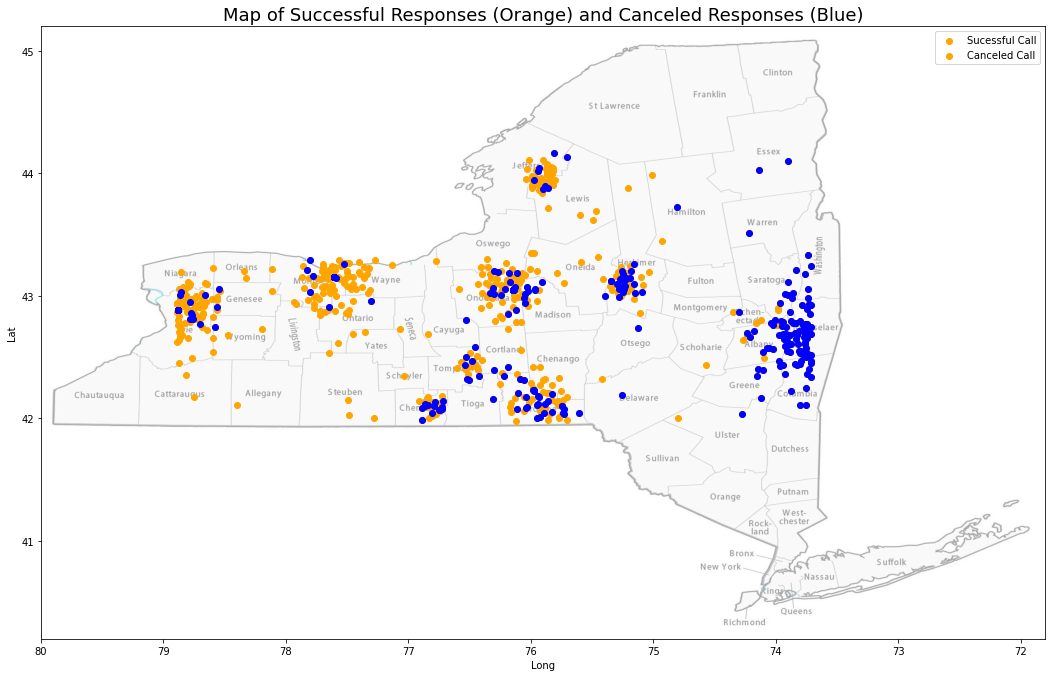

In [ ]:
plot_calls(arrival_calls, calls_canceled)

The number of total calls is 590
The number of canceled calls is 136
The percentage of dispatched calls is 78.64%

Average response time for a heli is 32.680588282521484 minutes
We end up transporting 0.1423728813559322 of calls to trauma centers
Average time to get to the hospital is 9.46468565991449 minutes

 The fraction of calls canceled is 0.2305084745762712
The response fraction is 0.7694915254237288 

The average call utilization of each helicopter per day is 2.7023809523809526
The utilization rate per each helicopter is {0: 3.857142857142857, 1: 1.2857142857142858, 2: 6.642857142857143, 3: 4.714285714285714, 4: 4.214285714285714, 5: 1.7857142857142858, 6: 6.285714285714286, 7: 3.9285714285714284, 8: 5.285714285714286, 9: 2.2142857142857144, 10: 0.7857142857142857, 11: 1.7857142857142858}
Helicopter with lowest utilization is heli # 10 with utilization of 0.7857142857142857
Helicopter with highest utilization is heli # 2 with utilization of 6.642857142857143

In [ ]:
haversine((42.8377876, 74.03638772), (42.683761, 73.733108))/160

0.18816138559494353

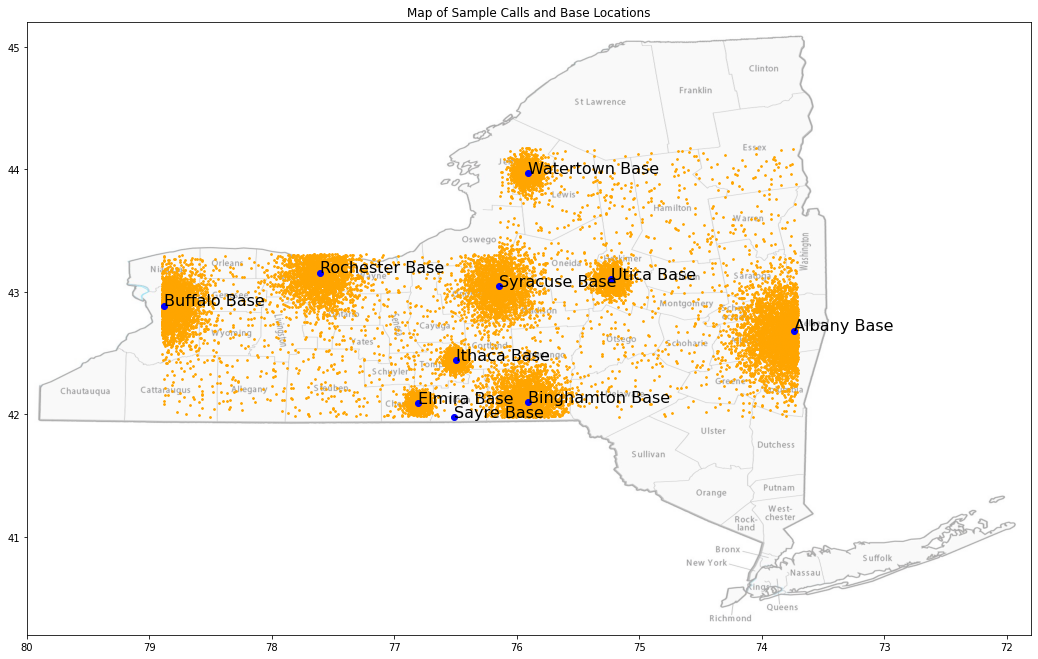

In [ ]:
latN = 45.2
latS = 40.2
lonW = 80.0
lonE = 71.8

lat_base = [base[0] for base in base_loc.values()]
lon_base = [base[1] for base in base_loc.values()]
import matplotlib.image as mpimg
fig = plt.figure(figsize=(18,12))
ny_img=mpimg.imread('/content/drive/My Drive/ny.jpeg') #https://gisgeography.com/wp-content/uploads/2020/02/New-York-County-Map.jpg
plt.title("Map of Sample Calls and Base Locations")
plt.imshow(ny_img, extent=[lonW, lonE, latS, latN], alpha=0.5)
plt.scatter(x=data_df["Lon"], y=data_df["Lat"], color = 'orange',zorder = 1,s =3 )
plt.scatter(x=lon_base, y=lat_base,color = 'blue',zorder = 2)
for i, txt in enumerate(base_loc.keys()):
    plt.text(lon_base[i], lat_base[i],txt+' Base', size = 16)